# Feature performance comparison

The purpose of this notebook is to compare the classification performance of the individual features, and their combination, for A. Thaliana

# Imports

In [1]:
from subpred.transporter_dataset import create_dataset
from subpred.eval import (
    get_independent_test_set,
    optimize_hyperparams,
    preprocess_pandas,
    models_quick_compare,
    get_confusion_matrix,
    get_classification_report,
    full_test,
    quick_test
)
from subpred.plots import pca_plot_2d, pca_plot_3d
from subpred.util import get_feature_score
from subpred.pssm import calculate_pssms_notebook
import pandas as pd
import seaborn as sns

# Dataset

In [2]:
df = create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Membrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="remove",
    outliers=["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"],
    verbose=True,
    tax_ids_filter=[3702],
    output_log="../logs/athaliana_sugar_amino.log",
    sequence_clustering=70
)

cd-hit: clustered 165 sequences into 117 clusters at threshold 70


# Feature generation

In [3]:
labels = df.keywords_transport
labels.value_counts()

Sugar transport         84
Amino-acid transport    33
Name: keywords_transport, dtype: int64

In [4]:
df_pssm = calculate_pssms_notebook(df.sequence)
df_pssm

,AA_50_1,AR_50_1,AN_50_1,AD_50_1,AC_50_1,AQ_50_1,AE_50_1,AG_50_1,AH_50_1,AI_50_1,...,VL_90_3,VK_90_3,VM_90_3,VF_90_3,VP_90_3,VS_90_3,VT_90_3,VW_90_3,VY_90_3,VV_90_3
Uniprot,,,,,,,,,,,,,,,,,,,,,
Q9SFG0,0.784223,0.252900,0.327146,0.238979,0.394432,0.350348,0.276102,0.545244,0.227378,0.317865,...,0.434307,0.381387,0.421533,0.578467,0.357664,0.390511,0.392336,0.512774,0.656934,0.417883
Q84WN3,0.664740,0.416185,0.462428,0.427746,0.624277,0.445087,0.456647,0.526012,0.479769,0.543353,...,0.383260,0.264317,0.374449,0.726872,0.215859,0.286344,0.312775,0.493392,0.982379,0.352423
O04249,0.735484,0.286022,0.352688,0.281720,0.479570,0.352688,0.318280,0.531183,0.279570,0.417204,...,0.476898,0.415842,0.471947,0.592409,0.387789,0.415842,0.422442,0.514851,0.702970,0.450495
Q56ZZ7,0.798913,0.173913,0.217391,0.153986,0.389493,0.251812,0.190217,0.481884,0.148551,0.367754,...,0.488636,0.433442,0.472403,0.608766,0.420455,0.461039,0.462662,0.514610,0.657468,0.470779
Q8H184,0.652482,0.308511,0.372340,0.269504,0.510638,0.365248,0.301418,0.457447,0.368794,0.425532,...,0.486772,0.391534,0.473545,0.595238,0.370370,0.417989,0.431217,0.505291,0.679894,0.473545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q94B65,0.814126,0.304833,0.408922,0.271375,0.579926,0.408922,0.349442,0.516729,0.334572,0.539033,...,0.542056,0.489097,0.529595,0.716511,0.426791,0.523364,0.504673,0.613707,0.894081,0.520249
Q0WWW9,0.760736,0.388037,0.424847,0.380368,0.556748,0.412577,0.423313,0.532209,0.375767,0.469325,...,0.544582,0.465021,0.515775,0.632373,0.455418,0.486968,0.482853,0.539095,0.703704,0.514403
Q2V4B9,0.800373,0.294776,0.341418,0.298507,0.468284,0.386194,0.386194,0.537313,0.261194,0.414179,...,0.521151,0.495770,0.510998,0.566836,0.477157,0.502538,0.502538,0.509306,0.602369,0.500846


## Independent test set

In [5]:
X, y, feature_names, sample_names = preprocess_pandas(
    df_pssm, labels, return_names=True
)
(
    X_train,
    X_test,
    y_train,
    y_test,
    sample_names_train,
    sample_names_test,
) = get_independent_test_set(X, y, sample_names=sample_names, test_size=0.2)



## Model comparison

In [6]:
models_quick_compare(X_train, y_train)

,0,1,2,3,4,mean,std
est,,,,,,,
GaussianNB(),0.782,0.782,0.878,0.862,0.585,0.778,0.117
KNeighborsClassifier(),0.864,0.683,0.936,0.926,0.734,0.829,0.114
"LinearSVC(class_weight='balanced', max_iter=1000000.0, random_state=0)",0.878,0.864,0.887,0.875,0.875,0.876,0.008
"LinearSVC(max_iter=1000000.0, random_state=0)",0.878,0.864,0.887,0.875,0.875,0.876,0.008
"RandomForestClassifier(class_weight='balanced', random_state=0)",0.737,0.842,0.864,1.000,0.839,0.857,0.094
RandomForestClassifier(random_state=0),0.683,0.842,1.000,0.926,0.839,0.858,0.118
SGDClassifier(random_state=0),0.825,0.936,0.835,0.935,0.819,0.870,0.060
"SVC(class_weight='balanced', random_state=0)",1.000,0.927,1.000,1.000,1.000,0.985,0.033
SVC(random_state=0),0.737,0.842,0.936,1.000,0.734,0.850,0.118


## Investigation of the dataset

The SVC results are surprisingly good, let's look at the data:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

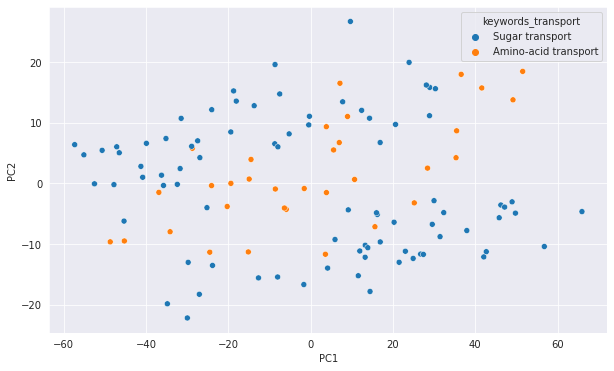

In [7]:

pca_plot_2d(df_pssm, labels)
# pca_plot_3d(df_pssm, labels)

It seems like sugar has higher variance in PC2. The pattern of sugar transporters having higher variance persists.

The PSSM feature encodes the likelyhood of amino acid exchanges from BLAST searches, which find proteins with similar sequences. A large number of similar proteins is available for virtually all proteins. The PSSM feature is a measure of amino acid conservation throughout evolution, not of the sequences themselves. When analyzing the amino acid composititons of the individual proteins, we found that the most important AAs are among the least frequent ones. What amino acids are the most common in the top-50 performing features?

<AxesSubplot:>

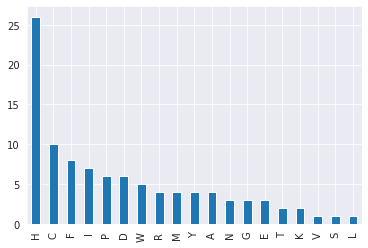

In [8]:
get_feature_score(df_pssm, labels).sort_values(
    "Normalized score", ascending=False
).iloc[:50, :].Feature.apply(lambda x: [x[0], x[1]]).explode().value_counts().plot.bar()

There is a disproportionate amount of histidine exchanges among the 50 best features according to ANOVA F-score. It seems like the likelyhood of exchanging histidine during evolution is related to the class distinction between sugar and amino acid transporters. How do the actual features look like?

In [9]:
get_feature_score(df_pssm, labels).sort_values(
    "Normalized score", ascending=False
).head(20)#.Feature.apply(lambda x: [x[0], x[1]])

,Feature,Normalized score,Measure
568,HH_50_3,0.011996,Feature importance (f_classif)
564,HC_50_3,0.009336,Feature importance (f_classif)
578,HY_50_3,0.008544,Feature importance (f_classif)
577,HW_50_3,0.008169,Feature importance (f_classif)
424,RC_50_3,0.006735,Feature importance (f_classif)
724,TC_50_3,0.006594,Feature importance (f_classif)
589,II_50_3,0.006264,Feature importance (f_classif)
749,WI_50_3,0.006147,Feature importance (f_classif)
573,HF_50_3,0.006110,Feature importance (f_classif)
569,HI_50_3,0.005786,Feature importance (f_classif)


The most important feature is the Histidine-Histidine exchange rate, which is equivalent to its conservation. What is the difference in His conservation across the classes?

<AxesSubplot:xlabel='keywords_transport', ylabel='HH_50_3'>

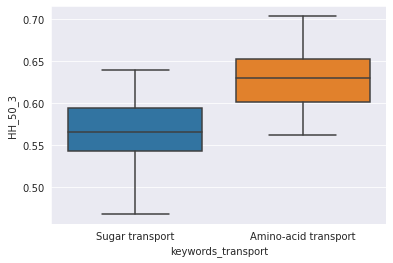

In [10]:
sns.boxplot(data=df_pssm, x=labels, y="HH_50_3")

Histidine conservation is greater in AA transporters.

I do not think that information sharing is a reason for the good results, it just seems like Histidine conservation and exchange rates are a good measure for distinguishing sugar and amino-acid transporters. 

Another interesting observation is that the top 17 features all stem from BLAST searches performed on Uniref50, with three iterations of Psiblast. These are the most distantly related proteins, but the 50% threshold of Uniref50 includes more of them. It could be that these parameters include more distantly related transporters, like splice variants for example, and therefore provide a clearer picture of the differences, especially in the His content.

Does the choice of training and validation set influence the results?

In [11]:
repetitions = 20
df_stats, _ = full_test(df_pssm, labels, repetitions=repetitions)
df_stats_gr = df_stats.groupby(["label", "dataset"], as_index=False)
print(f"mean ({repetitions} runs)")
display(df_stats_gr.mean().pivot("label", "dataset", "F1 score"))
print(f"sdev ({repetitions} runs)")
df_stats_gr.std().pivot("label", "dataset", "F1 score")

mean (20 runs)


dataset,test,train
label,,
Amino-acid transport,0.9458,0.91550
Sugar transport,0.9798,0.96965


sdev (20 runs)


dataset,test,train
label,,
Amino-acid transport,0.053032,0.040288
Sugar transport,0.018693,0.014572


The scores drop by about 5% on average with the default parameter grid, by choosing independent test splits with 20 different random_states other than the default (42). This seems more reasonable than getting 1.0 for almost every fold.

(Note: I finished the analysis before testing this, so the slight overfitting on the test set happened by chance.)

## Parameter tuning

#### Custom transformer

Here, we try the multi-pssm feature, which tries all combinations of feature generation parameters, and selects the best ones based on the training set.

Whole dataset, linear svm

In [12]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="linear",
    dim_reduction=None,
    C=[10, 100, 1000],
)
best_estimator_svc = gsearch


{'linearsvc__C': 100, 'linearsvc__class_weight': None, 'linearsvc__dual': False, 'linearsvc__max_iter': 100000000.0}
0.959


Good results, but relatively high value for C. With the custom transformer:

In [13]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="linear",
    dim_reduction=None,
    C=[1, 10, 100],
    feature_transformer="pssm",
    feature_names=feature_names,
)
best_estimator_svc = gsearch


{'linearsvc__C': 10, 'linearsvc__class_weight': 'balanced', 'linearsvc__dual': False, 'linearsvc__max_iter': 100000000.0, 'pssmselector__iterations': 3, 'pssmselector__uniref_threshold': 50}
0.987


Lower value of C, better results. Does RBF improve anything?

In [14]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction=None,
    C=[0.1, 1, 10],
)
best_estimator_svc = gsearch

{'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.985


This works with C and gamma at their default values. What about the transformer?

In [15]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction=None,
    C=[0.1, 1, 10],
    feature_transformer="pssm",
    feature_names=feature_names,
)
best_estimator_svc = gsearch

{'pssmselector__iterations': 1, 'pssmselector__uniref_threshold': 90, 'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.987


This time, the transformer actually selects the Uniref90 PSSMs with one iteration of Psiblast, instead of Uniref50 + 3 iterations, which was also selected by the feature importance scores above.

## Dimensionality reduction

Trying only in steps of 20, to reduct runtime. With the linear kernel, we get the high C again:

In [16]:
gsearch = optimize_hyperparams(
    X_train, y_train, kernel="linear", dim_reduction="kbest", C=[10, 100, 1000], select_k_steps=20
)
best_estimator_svc_kbest = gsearch

{'linearsvc__C': 100, 'linearsvc__class_weight': None, 'linearsvc__dual': False, 'linearsvc__max_iter': 100000000.0, 'selectkbest__k': 1221}
0.974


In [17]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="linear",
    dim_reduction="pca",
    # feature_transformer="pssm",
    # feature_names=feature_names,
    # C=[0.1, 0.01, 0.001],
    # gamma=[0.1, 0.01, 0.001],
)


{'linearsvc__C': 1, 'linearsvc__class_weight': 'balanced', 'linearsvc__dual': True, 'linearsvc__max_iter': 100000000.0, 'pca__n_components': 0.98}
0.987


PCA seems to perform the best and is faster, how about the RBF kernel?

In [18]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction="pca",
    # feature_transformer="pssm",
    # feature_names=feature_names,
    C=[1, 10,100],
    gamma=["scale", 0.1, 0.01, 0.001],
)
best_estimator_svc_pca = gsearch

{'pca__n_components': 0.96, 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 0.01}
0.987


With the custom transformer, rbf and pca, we get a perfect score:

In [19]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction="pca",
    feature_transformer="pssm",
    feature_names=feature_names,
    C=[1, 0.1, 10],
    gamma=["scale", 0.1, 0.01, 0.001],
)
best_estimator_svc_pca = gsearch

{'pca__n_components': 0.96, 'pssmselector__iterations': 3, 'pssmselector__uniref_threshold': 'all', 'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 0.01}
1.0


## Validation

And that perfect score also happens on the validation set! Both for PCA, and Kbest

### Kbest

In [20]:
get_confusion_matrix(X_test, y_test, best_estimator_svc_kbest, labels=labels)

predicted,Amino-acid transport,Sugar transport
observed,,
Amino-acid transport,7,0
Sugar transport,0,17


In [21]:
get_classification_report(X_test, y_test, best_estimator_svc_kbest, labels=labels)

,precision,recall,f1-score,support
Amino-acid transport,1.0,1.0,1.0,7
Sugar transport,1.0,1.0,1.0,17
macro avg,1.0,1.0,1.0,24
weighted avg,1.0,1.0,1.0,24


### PCA

In [22]:
get_confusion_matrix(X_test, y_test, best_estimator_svc_pca, labels=labels)

predicted,Amino-acid transport,Sugar transport
observed,,
Amino-acid transport,7,0
Sugar transport,0,17


In [23]:
get_classification_report(X_test, y_test, best_estimator_svc_pca, labels=labels)

,precision,recall,f1-score,support
Amino-acid transport,1.0,1.0,1.0,7
Sugar transport,1.0,1.0,1.0,17
macro avg,1.0,1.0,1.0,24
weighted avg,1.0,1.0,1.0,24


## Estimating validation variance

How much did the result depend on choosing the training and test sets?

Mean and standard deviation for randomly selected training and validation sets.

In [24]:
df_scores, df_params = full_test(
    df_pssm,
    labels,
    dim_reduction="pca",
    kernel="rbf",
    repetitions=10,
    feature_transformer="pssm",
)
df_scores_gr = df_scores.groupby(["label", "dataset"], as_index=False)
print("Mean F1")
display(df_scores_gr.mean().pivot(index="label", columns="dataset", values="F1 score"))
print("Sdev F1")
display(df_scores_gr.std().pivot(index="label", columns="dataset", values="F1 score"))
print("Parameters")
display(df_params)

Mean F1


dataset,test,train
label,,
Amino-acid transport,0.9536,0.9960
Sugar transport,0.9827,0.9986


Sdev F1


dataset,test,train
label,,
Amino-acid transport,0.065546,0.008433
Sugar transport,0.024281,0.002951


Parameters


,0,1,2,3,4,5,6,7,8,9
pca__n_components,0.95,0.94,0.98,0.92,0.95,0.82,0.96,0.96,0.92,0.99
pssmselector__iterations,3,all,3,1,all,3,1,3,3,3
pssmselector__uniref_threshold,all,all,50,50,all,50,90,all,50,50
svc__C,1,1,10,1,1,1,10,1,10,1
svc__class_weight,balanced,balanced,balanced,None,balanced,balanced,balanced,balanced,balanced,balanced
svc__gamma,0.01,scale,0.01,scale,0.01,scale,0.01,0.01,0.01,0.01


There is some variance in choosing the PSSM parameters across the splits. What if we set it to only Uniref50/3 iterations?

In [25]:
df_pssm_50_3 = df_pssm.loc[:,df_pssm.columns.str.endswith("50_3")]

df_pssm_50_3

,AA_50_3,AR_50_3,AN_50_3,AD_50_3,AC_50_3,AQ_50_3,AE_50_3,AG_50_3,AH_50_3,AI_50_3,...,VL_50_3,VK_50_3,VM_50_3,VF_50_3,VP_50_3,VS_50_3,VT_50_3,VW_50_3,VY_50_3,VV_50_3
Uniprot,,,,,,,,,,,,,,,,,,,,,
Q9SFG0,0.817597,0.281116,0.349785,0.240343,0.379828,0.394850,0.315451,0.590129,0.236052,0.324034,...,0.549356,0.469957,0.536481,0.643777,0.459227,0.484979,0.484979,0.637339,0.701717,0.508584
Q84WN3,0.695000,0.340000,0.370000,0.320000,0.590000,0.360000,0.355000,0.525000,0.330000,0.600000,...,0.485000,0.290000,0.490000,0.840000,0.205000,0.385000,0.385000,0.545000,1.000000,0.435000
O04249,0.772643,0.349353,0.397412,0.327172,0.462107,0.414048,0.367837,0.609982,0.327172,0.462107,...,0.567468,0.495379,0.548983,0.639556,0.493530,0.502773,0.512015,0.606285,0.709797,0.530499
Q56ZZ7,0.812925,0.188776,0.234694,0.159864,0.409864,0.256803,0.214286,0.561224,0.173469,0.433673,...,0.530612,0.459184,0.525510,0.664966,0.438776,0.511905,0.510204,0.554422,0.695578,0.511905
Q8H184,0.781931,0.320872,0.389408,0.286604,0.560748,0.404984,0.342679,0.548287,0.380062,0.485981,...,0.610592,0.492212,0.626168,0.700935,0.467290,0.538941,0.557632,0.613707,0.722741,0.613707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q94B65,0.802260,0.375706,0.401130,0.324859,0.590395,0.446328,0.384181,0.573446,0.372881,0.612994,...,0.598870,0.525424,0.587571,0.751412,0.460452,0.550847,0.545198,0.692090,0.858757,0.584746
Q0WWW9,0.811047,0.428779,0.463663,0.436047,0.607558,0.450581,0.460756,0.611919,0.404070,0.529070,...,0.598837,0.502907,0.590116,0.703488,0.497093,0.555233,0.547965,0.590116,0.725291,0.566860
Q2V4B9,0.840367,0.315596,0.374312,0.346789,0.495413,0.405505,0.403670,0.601835,0.295413,0.475229,...,0.609174,0.565138,0.607339,0.653211,0.541284,0.583486,0.585321,0.596330,0.678899,0.579817


In [26]:
df_scores, df_params = full_test(
    df_pssm_50_3,
    labels,
    dim_reduction="pca",
    kernel="rbf",
    repetitions=10,
    # feature_transformer="pssm",
)
df_scores_gr = df_scores.groupby(["label", "dataset"], as_index=False)
print("Mean F1")
display(df_scores_gr.mean().pivot(index="label", columns="dataset", values="F1 score"))
print("Sdev F1")
display(df_scores_gr.std().pivot(index="label", columns="dataset", values="F1 score"))
print("Parameters")
display(df_params)

Mean F1


dataset,test,train
label,,
Amino-acid transport,0.9469,0.9881
Sugar transport,0.9797,0.9957


Sdev F1


dataset,test,train
label,,
Amino-acid transport,0.063674,0.010246
Sugar transport,0.023754,0.003713


Parameters


,0,1,2,3,4,5,6,7,8,9
pca__n_components,0.94,0.83,0.98,0.95,0.86,0.82,0.97,0.87,0.92,0.99
svc__C,1,1,10,10,1,1,1,1,10,1
svc__class_weight,balanced,balanced,balanced,balanced,None,balanced,balanced,None,balanced,balanced
svc__gamma,0.01,scale,0.01,0.01,0.1,scale,0.01,0.1,0.01,0.01


This version without the feature parameter selector doesn't take as long to calculate, but the multi-pssm version with the transformer above has higher scores.